Group PGH013: Dhruv Baid, Guolun Li, Shangyu Li, Uday Sharma, Yi Xin Xiang

In [15]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.util import mark_negation
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings("ignore")
plt.style.use("seaborn")

**Preprocessing – delete once merged**

In [54]:
df = pd.read_csv('OFFERING.tsv', sep='\t')

In [55]:
df.loc[df.HASNONACCREDITEDINVESTORS == False,'NUMBERNONACCREDITEDINVESTORS']\
     =df[df.HASNONACCREDITEDINVESTORS == False].\
        NUMBERNONACCREDITEDINVESTORS.fillna(0)

df.loc[df.TOTALNUMBERALREADYINVESTED < df.NUMBERNONACCREDITEDINVESTORS,\
     'TOTALNUMBERALREADYINVESTED'] = \
     df.loc[df.TOTALNUMBERALREADYINVESTED < \
        df.NUMBERNONACCREDITEDINVESTORS, 'NUMBERNONACCREDITEDINVESTORS']

df.IS40ACT = df.IS40ACT.fillna('Not Applicable')

df.INVESTMENTFUNDTYPE = df.INVESTMENTFUNDTYPE.fillna("Not Applicable")

df.REVENUERANGE = df.REVENUERANGE.fillna("Not Applicable")
df.AGGREGATENETASSETVALUERANGE = df.AGGREGATENETASSETVALUERANGE.\
    fillna("Not Applicable")

df.PREVIOUSACCESSIONNUMBER = df.PREVIOUSACCESSIONNUMBER.\
    fillna("Not Applicable")

df.YETTOOCCUR = df.YETTOOCCUR.fillna(False)
df.ISEQUITYTYPE = df.ISEQUITYTYPE.fillna(False)
df.ISDEBTTYPE = df.ISDEBTTYPE.fillna(False)
df.ISOPTIONTOACQUIRETYPE = df.ISOPTIONTOACQUIRETYPE.fillna(False)
df.ISSECURITYTOBEACQUIREDTYPE = df.ISSECURITYTOBEACQUIREDTYPE.fillna(False)
df.ISPOOLEDINVESTMENTFUNDTYPE = df.ISPOOLEDINVESTMENTFUNDTYPE.fillna(False)
df.ISTENANTINCOMMONTYPE = df.ISTENANTINCOMMONTYPE.fillna(False)
df.ISMINERALPROPERTYTYPE = df.ISMINERALPROPERTYTYPE.fillna(False)
df.ISOTHERTYPE = df.ISOTHERTYPE.fillna(False)

df.DESCRIPTIONOFOTHERTYPE = df.DESCRIPTIONOFOTHERTYPE.\
    fillna('Not Applicable')

df.BUSCOMBCLARIFICATIONOFRESP = df.BUSCOMBCLARIFICATIONOFRESP.\
    fillna("Not Applicable")
df.SALESAMTCLARIFICATIONOFRESP = df.SALESAMTCLARIFICATIONOFRESP.\
    fillna("Not Applicable")
df.FINDERFEECLARIFICATIONOFRESP = df.FINDERFEECLARIFICATIONOFRESP.\
    fillna("Not Applicable")
df.GROSSPROCEEDSUSED_CLAROFRESP = df.GROSSPROCEEDSUSED_CLAROFRESP.\
    fillna("Not Applicable")

df = df.drop(columns=['OVER100RECIPIENTFLAG'])

df.SALESCOMM_ISESTIMATE = df.SALESCOMM_ISESTIMATE.fillna(False)
df.FINDERSFEE_ISESTIMATE = df.FINDERSFEE_ISESTIMATE.fillna(False)
df.GROSSPROCEEDSUSED_ISESTIMATE = df.GROSSPROCEEDSUSED_ISESTIMATE.\
    fillna(False)

In [56]:
df.MINIMUMINVESTMENTACCEPTED = df.MINIMUMINVESTMENTACCEPTED.\
    astype('float64')
df.TOTALOFFERINGAMOUNT = df.TOTALOFFERINGAMOUNT.\
    replace('Indefinite',np.inf).astype('float64')
df.TOTALAMOUNTSOLD = df.TOTALAMOUNTSOLD.astype('float64')
df.TOTALREMAINING = df.TOTALREMAINING.replace('Indefinite',\
    np.inf).astype('float64')
df.NUMBERNONACCREDITEDINVESTORS = \
    df.NUMBERNONACCREDITEDINVESTORS.astype('float64')
df.TOTALNUMBERALREADYINVESTED = df.TOTALNUMBERALREADYINVESTED\
    .astype('int64')
df.SALESCOMM_DOLLARAMOUNT = df.SALESCOMM_DOLLARAMOUNT\
    .astype('float64')
df.FINDERSFEE_DOLLARAMOUNT = df.FINDERSFEE_DOLLARAMOUNT\
    .astype('float64')
df.GROSSPROCEEDSUSED_DOLLARAMOUNT = \
    df.GROSSPROCEEDSUSED_DOLLARAMOUNT.astype('float64')

df.ISAMENDMENT = df.ISAMENDMENT.astype(bool)
df.YETTOOCCUR = df.YETTOOCCUR.astype(bool)
df.MORETHANONEYEAR = df.MORETHANONEYEAR.astype(bool)
df.ISEQUITYTYPE = df.ISEQUITYTYPE.astype(bool)
df.ISDEBTTYPE = df.ISDEBTTYPE.astype(bool)
df.ISOPTIONTOACQUIRETYPE = df.ISOPTIONTOACQUIRETYPE.astype(bool)
df.ISSECURITYTOBEACQUIREDTYPE = df.ISSECURITYTOBEACQUIREDTYPE.astype(bool)
df.ISPOOLEDINVESTMENTFUNDTYPE = df.ISPOOLEDINVESTMENTFUNDTYPE.astype(bool)
df.ISTENANTINCOMMONTYPE = df.ISTENANTINCOMMONTYPE.astype(bool)
df.ISMINERALPROPERTYTYPE = df.ISMINERALPROPERTYTYPE.astype(bool)
df.ISOTHERTYPE = df.ISOTHERTYPE.astype(bool)
df.ISBUSINESSCOMBINATIONTRANS = df.ISBUSINESSCOMBINATIONTRANS.astype(bool)
df.HASNONACCREDITEDINVESTORS = df.HASNONACCREDITEDINVESTORS.astype(bool)
df.SALESCOMM_ISESTIMATE = df.SALESCOMM_ISESTIMATE.astype(bool)
df.FINDERSFEE_ISESTIMATE = df.FINDERSFEE_ISESTIMATE.astype(bool)
df.GROSSPROCEEDSUSED_ISESTIMATE = df.GROSSPROCEEDSUSED_ISESTIMATE\
    .astype(bool)

df.INDUSTRYGROUPTYPE = df.INDUSTRYGROUPTYPE.astype('category')
df.INVESTMENTFUNDTYPE = df.INVESTMENTFUNDTYPE.astype('category')
df.IS40ACT = df.IS40ACT.astype('category')
df.REVENUERANGE = df.REVENUERANGE.astype('category')
df.AGGREGATENETASSETVALUERANGE = df.AGGREGATENETASSETVALUERANGE\
    .astype('category')
df.AUTHORIZEDREPRESENTATIVE = df.AUTHORIZEDREPRESENTATIVE.astype('category')

df.SALE_DATE = df.SALE_DATE.astype('datetime64')

**end delete**

# Analysis 1

**Question**: Are there variables in the data set that could help predict the percentage of offering sold?

**Methods Used**: Natural Language Processing, K-Means Clustering

## Methodology

First, we set up the response variable **y**, equal to the percentage of offering sold.

$$y = \frac{\mathrm{TOTALAMOUNTSOLD}}{\mathrm{TOTALOFFERINGAMOUNT}}$$

In [57]:
idx = (df.TOTALOFFERINGAMOUNT!=np.inf)
y = (df.TOTALAMOUNTSOLD[idx] / df.TOTALOFFERINGAMOUNT[idx])

Note that we discard the rows where the total offering amount is undetermined. We are left with 8,541 rows from the original 14,187.

In [58]:
len(y)

8541

For performing Natural Language Processing, we look at the following columns with text data:
- DESCRIPTIONOFOTHERTYPE
- BUSCOMBCLARIFICATIONOFRESP
- SALESAMTCLARIFICATIONOFRESP
- FINDERFEECLARIFICATIONOFRESP
- GROSSPROCEEDSUSED_CLAROFRESP

For the purposes of this analysis, the text "Not Applicable" is replaced with an empty string.

First, we tokenize each column using the following methodology:

1. Tokenize each cell by words, i.e., break it into a sequence of words.

2. Using regular expression, only keep words with alphanumeric characters or the "\$" sign. This will allow us to keep dollar amounts that are included in some of the descriptions, while removing punctuations.

3. Convert each word to lowercase *only if* it is not an acronym, defined here as a word that is completely uppercase. This allows us to treat acronyms like "SAFE" separately from the noun "safe". This will allow us to keep things like the "A" in "Series A", as it would otherwise get converted to "a" which is a stop word.

4. Remove English stop words using the built-in dictionary in *nltk*.

5. Parse each word and tag it with the appropriate part of speech using the standard Penn Treebank tagset.

6. Using these tags, lemmatize each word using *nltk*'s implementation of WordNet. For words without any tag, e.g. the dollar sign \$, we keep the word as-is.

7. Finally, perform negation handling by marking each word following a negation word with the "_NEG" tag.

In [59]:
text_cols = ['DESCRIPTIONOFOTHERTYPE','BUSCOMBCLARIFICATIONOFRESP','SALESAMTCLARIFICATIONOFRESP','FINDERFEECLARIFICATIONOFRESP','GROSSPROCEEDSUSED_CLAROFRESP']

# replace "Not Applicable" with an empty string
# extract the text cols for rows for which offering amount is not indefinite
X_input = df[text_cols][idx].replace("Not Applicable",'')

# initialize lemmatizer and stop words
lem = WordNetLemmatizer().lemmatize
stop_words = set(stopwords.words('english'))

# to print random values for demonstration purposes
print_bool = True
print_idx = np.random.choice(list(range(len(X_input)*len(text_cols))),50)
if not print_bool:
    print_idx = []
curr_idx = 0

# function to tokenize each cell
def tokenize(string):

    # for printing examples
    global curr_idx
    curr_idx+=1

    # for an empty string, just return an empty list
    if string=='':
        return []

    # step 1: tokenize by words
    wt = word_tokenize(string)
    
    # step 2: keep words with alphanumeric characters or $
    wt = [word for word in wt if re.match("[a-zA-Z\$0-9].*",word) is not None]

    # step 3: convert to lowercase only if not an acronym
    wt = list(map(lambda x: x if x.isupper() else x.lower(),wt))
    
    # step 4: remove stop words
    wt = [w for w in wt if not w in stop_words]

    # step 5: tag with the appropriate part of speech
    wt = nltk.pos_tag_sents([wt])[0]

    # step 6: lemmatize each word
    holdsent = list(wt)
    for i, wordtuple in enumerate(holdsent):
        wordtmp = list(wordtuple)
        if(wordtmp[1].startswith('N')):
            wordtmp[1] = lem(wordtmp[0], 'n')
        elif(wordtmp[1].startswith('V')):
            wordtmp[1] = lem(wordtmp[0], 'v')
        elif(wordtmp[1].startswith('J')):
            wordtmp[1] = lem(wordtmp[0], 'a')
        elif(wordtmp[1].startswith('R')):
            wordtmp[1] = lem(wordtmp[0], 'r')
        else:
            wordtmp[1] = None
        holdsent[i] = wordtmp
    wt = list(map(lambda x: x[1] if x[1] is not None else x[0], holdsent))

    # step 7: negation handling
    wt = mark_negation(wt)
    
    # for printing examples
    if curr_idx in print_idx:
        print("Original:",string)
        print("After tokenization:",wt)
        print()
        
    return wt

Now, we apply the tokenize function to each column.

To illustrate the tokenization process, we randomly sample a few examples and print the original string, as well as the tokenized version.

In [60]:
for col in text_cols:
    X_input[col] = X_input[col].apply(tokenize)

Original: Convertible debentures and Common Stock issuable upon conversion
After tokenization: ['convertible', 'debenture', 'common', 'stock', 'issuable', 'upon', 'conversion']

Original: 6% Convertible Note  convertible into shares of common stock upon close of IPO
After tokenization: ['6', 'convertible', 'note', 'convertible', 'share', 'common', 'stock', 'upon', 'close', 'IPO']

Original: The Total Offering Amount and Total Remaining to be Sold include amounts being offered by Columbia Capital Opportunities Fund I-A, L.P., a "parallel fund" of the Issuer.
After tokenization: ['total', 'offering', 'amount', 'total', 'remain', 'sell', 'include', 'amount', 'offer', 'columbia', 'capital', 'opportunity', 'fund', 'I-A', 'L.P.', 'parallel', 'fund', 'issuer']

Original: Loan origination fee
After tokenization: ['loan', 'origination', 'fee']

Original: Sales Commissions include estimates of the maximum amount of Selling Commissions and Dealer Fees that may be paid.
After tokenization: ['sale'

We note that the resulting matrix is quite sparse – the empty list seems to be a big proportion of all five columns. To tackle this, we concatenate the columns into a single column called "*combined_text*", with the following justifications:
- Upon observing the data on Excel, we find that for a majority of the cases, there is not much of an overlap between columns being non-empty, i.e., there are very few rows where we have two or more columns being non-empty.
- Also, our analysis afterwards consists of a "bag-of-words" model for the text. With that in mind, simply concatenating the columns together doesn't adversely affect the analysis as we will still be evaluating how "similar" two rows are based on the words that show up in the different descriptions provided.

In [61]:
#X_input.to_excel("test.xlsx")
X_input.describe()

,DESCRIPTIONOFOTHERTYPE,BUSCOMBCLARIFICATIONOFRESP,SALESAMTCLARIFICATIONOFRESP,FINDERFEECLARIFICATIONOFRESP,GROSSPROCEEDSUSED_CLAROFRESP
count,8541,8541,8541,8541,8541
unique,358,76,645,286,843
top,[],[],[],[],[]
freq,7839,8456,7695,8047,5677


In [62]:
X_input['combined_text'] = X_input.apply(lambda x: x[0]+x[1]+x[2]+x[3]+x[4],axis=1)
X_input.combined_text = list(map(lambda x: x if x else np.nan, X_input.combined_text))

After combining the data, we drop the rows that have an empty list. We are left with 3938 rows, which is still a good enough amount of data for further analysis.

In [65]:
idx_pick = X_input.combined_text.dropna().index
X, y = X_input.combined_text[idx_pick], y[idx_pick]

In [66]:
len(X)

3938

Next, we want to make use of the tokenized data to get insights about our original data. To do so, we use the term frequency-inverse document frequecy (TF-IDF) metric, which creates a matrix of "adjusted" counts, where the number of rows is equal to 3938 (as found above), and the number of columns is equal to the number of unique terms across the documents.

Here, the adjustment to the counts is done to account for the term's frequency across the documents.

A note on implementation: as the *TfidfVectorizer* function automatically performs preprocessing and tokenizing, we pass a "dummy" preprocessor and tokenizer each as we have already done both the procedures in the previous steps.

Also, we set the ngram_range to (1,1). The justification for this is that since we're looking at financial data, it is unlikely that looking at a longer combination of words will give any more information than looking at a single word. For example, the words "common" and "stock" are usually used together. It is very unlikely that, for example, the word "common" is used in a different context – and that we get more value by looking at "common stock" as a unit.

In [67]:
def dummy_tokenizer(sent):
    return sent

def dummy_preprocessor(sent):
    return sent

vectorizer = TfidfVectorizer(tokenizer = dummy_tokenizer, preprocessor=dummy_preprocessor,ngram_range=(1,1))
vect_fit = vectorizer.fit_transform(list(X))

Before further analysis, we first divide the response, the percentage of offering sold, into bins. Looking at the histogram:

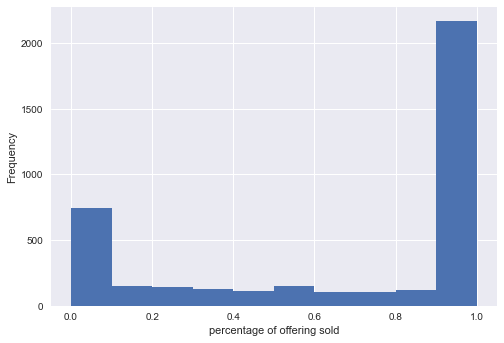

In [74]:
y.plot.hist(bins=10)
plt.xlabel("percentage of offering sold")
plt.show()

Based on this, we make 5 bins for the following range of values:
1. [0, 0.2]
2. (0.2, 0.4]
3. (0.4, 0.6]
4. (0.6, 0.8]
5. (0.8, 1]

In [81]:
def bin_proportion(val, num_bins = 5):
    size = 1/num_bins
    i = size
    while val >= i:
        i += size
    return int(i//size)
        
y_binned = y.apply(bin_proportion)

Now, the final step of the analysis is to use K-means clustering to group the data into different clusters using the TF-IDF matrix. 

We use K-means clustering as the "inertia", a function of the squared euclidean norm, is a fairly good measure of similarity between different rows in the matrix since all the data are at the same scale. Hence, it would be valid to treat the distances between different columns the same way.

We set the number of clusters to 8, a number slightly higher than 5, as we want to be able to "sieve out" the different bins for y into different clusters. In other words, we want to try to get clusters (constructed for the TF-IDF matrix) where a majority of the members belong to a single binned value of y. This is ideal as we already know that the cluster contains members which are similar in terms of the text the features contain, so we can then try to find common characteristics between the members of that cluster. This will allow us to identify certain texts which can help predict the percentage of offering that ends up getting sold.

In [86]:
from sklearn.cluster import KMeans
kminit = KMeans(n_clusters=8, n_init=100)
kmout = kminit.fit(vect_fit.todense())

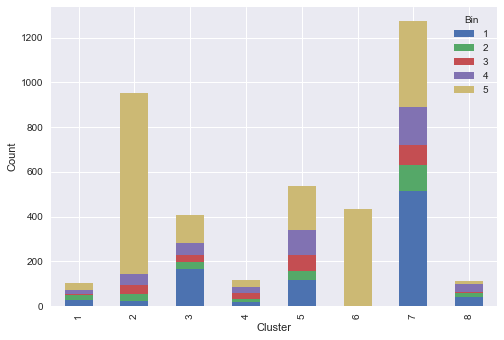

In [87]:
plot_df = pd.DataFrame(df.ACCESSIONNUMBER[X.index])
plot_df['kmclust'] = kmout.labels_ + 1
plot_df['kmclust'] = plot_df['kmclust'].astype('category').cat.as_unordered()
plot_df['actual_bin'] = y_binned.copy()

plot_df = plot_df.groupby(['kmclust','actual_bin'])['ACCESSIONNUMBER'].count().unstack('actual_bin').fillna(0)
plot_df.plot(kind='bar', stacked=True,legend=False)
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Bin", bbox_to_anchor=(1.0, 1.0))
plt.show()

## Analysis and Results

### Clusters 2 and 6: high percentage of offerings sold

First, we note that clusters 2 and 6 have a majority of its members belonging to bin 5, i.e., have a percentage of offering sold between 0.8 to 1. We look at the text features of this data on Excel. 

To visualize and understand the data better, we first visually inspect the features for the cluster, and then print the unique values from the important column(s).

Cluster 2:

In [118]:
idx = y_binned[kmout.labels_ == 1].index
#df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].to_excel('test.xlsx')
df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].head(5)

,DESCRIPTIONOFOTHERTYPE,BUSCOMBCLARIFICATIONOFRESP,SALESAMTCLARIFICATIONOFRESP,FINDERFEECLARIFICATIONOFRESP,GROSSPROCEEDSUSED_CLAROFRESP,TOTALOFFERINGAMOUNT,TOTALAMOUNTSOLD
2,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time fixed cost t...,213278.0,213278.0
12,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time fixed cost t...,145628.0,145628.0
25,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time fixed cost t...,550000.0,550000.0
58,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time fixed cost t...,164500.0,164500.0
62,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time fixed cost t...,86493.0,86493.0


In [122]:
print("GROSSPROCEEDSUSED_CLAROFRESP:")
examples = df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].GROSSPROCEEDSUSED_CLAROFRESP.unique()
examples = [item for item in examples if item != "Not Applicable"]
for item in examples:
    print(item)

GROSSPROCEEDSUSED_CLAROFRESP:
This amount represents a one-time cost to cover fund organizational and operating expenses.
This amount represents a one time fixed cost to cover fund organizational and operating expenses.
This amount represents a cost to cover fund organizational and operating expenses.
This amount represents a one-time fixed cost to cover fund organizational and operating expenses.
This amount represents a one-time cost to cover the fund organizational and operating expenses.
This amount represents a one-time cost to cover the organizational and operating expenses.
This amount represents a one-time cost fee to cover the organizational and operating expenses.


Cluster 6:

In [119]:
idx = y_binned[kmout.labels_ == 5].index
#df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].to_excel('test.xlsx')
df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].head(5)

,DESCRIPTIONOFOTHERTYPE,BUSCOMBCLARIFICATIONOFRESP,SALESAMTCLARIFICATIONOFRESP,FINDERFEECLARIFICATIONOFRESP,GROSSPROCEEDSUSED_CLAROFRESP,TOTALOFFERINGAMOUNT,TOTALAMOUNTSOLD
29,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time cost to cove...,1055000.0,1055000.0
32,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time cost to cove...,750000.0,750000.0
34,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time cost to cove...,2041200.0,2041200.0
329,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time cost to cove...,470000.0,470000.0
331,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time cost to cove...,34442.0,34442.0


In [123]:
print("GROSSPROCEEDSUSED_CLAROFRESP:")
examples = df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].GROSSPROCEEDSUSED_CLAROFRESP.unique()
examples = [item for item in examples if item != "Not Applicable"]
for item in examples:
    print(item)

GROSSPROCEEDSUSED_CLAROFRESP:
This amount represents a one-time cost to cover fund organizational and operating expenses.
This amount represents a one time fixed cost to cover fund organizational and operating expenses.
This amount represents a cost to cover fund organizational and operating expenses.
This amount represents a one-time fixed cost to cover fund organizational and operating expenses.
This amount represents a one-time cost to cover the fund organizational and operating expenses.
This amount represents a one-time cost to cover the organizational and operating expenses.
This amount represents a one-time cost fee to cover the organizational and operating expenses.


Upon inspecting the files, we notice a common feature to almost all the entries with 100% securities sold: the string "one-time cost to cover organizational and operating expenses" showing up in the clarification provided to the gross proceeds used.

This can be a predictor for the percentage of securities sold – if a company makes a one-time payment to its promoters using the proceeds of its sales, and if it can be determined that it's for the organizational and operating expenses, then it's likely that the company will sell all of its offerings.

As a proxy for the numerical estimate for the likelihood that a listing with this characteristic has a good sales proportion (between 0.8 to 1), we look at the proportion of members of clusters 2 and 6 that belong to bin 5.

To justify this assumption, we use the following reasoning – the members belonging to a cluster are similar, and we can assume that the clustering is exhaustive, i.e., all the data that has this particular characteristic belongs to the cluster. In this case, we combine clusters 2 and 6 since we've found them to exhibit similar characteristics.

In [143]:
round(np.where(y_binned[(kmout.labels_ == 1) | (kmout.labels_ == 5)]==5,1,0).mean(),4)

0.8963

The interpretation is that if a company makes a one-time payment to its promoters using the proceeds of its sales, and if it can be determined that it's for the organizational and operating expenses, there's a likelihood of 89.63% that it sells 80-100% of its offerings.

### Cluster 8: low percentage of offerings sold

Next, we look at cluster 8, which contains a majority of its members in bins other than 5, i.e., it's likely that the firm does not sell all of its securities. Further, we see that around half of the members are in bins 1 and 2, meaning that the firm sells less than 40% of its securities.

We follow a similar approach as before: visually inspect the data to recognize important columns, then print the unique values from those columns.

In [132]:
idx = y_binned[kmout.labels_ == 7].index
#df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].to_excel('test.xlsx')
df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].head(5)

,DESCRIPTIONOFOTHERTYPE,BUSCOMBCLARIFICATIONOFRESP,SALESAMTCLARIFICATIONOFRESP,FINDERFEECLARIFICATIONOFRESP,GROSSPROCEEDSUSED_CLAROFRESP,TOTALOFFERINGAMOUNT,TOTALAMOUNTSOLD
434,Not Applicable,Not Applicable,"Regarding Item 11, the Issuer may accept small...",Not Applicable,Not Applicable,500000000.0,189725000.0
607,Not Applicable,Not Applicable,"Regarding Item 11, the Issuer may accept small...",Sales Commissions include estimates of the max...,"Item 16 is an estimate of acquisition fees, re...",209327056.0,75265986.0
631,Not Applicable,Not Applicable,"Regarding Item 11, the Issuer may accept small...",Sales Commissions include estimates of the max...,"Item 16 is an estimate of acquisition fees, re...",49986820.0,49971932.0
639,Not Applicable,Not Applicable,"Regarding Item 11, the Issuer may accept small...",Sales Commissions include estimates of the max...,"Item 16 is an estimate of acquisition fees, re...",79741563.0,79578887.0
966,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Acquisition Fee,2500000.0,250000.0


In [133]:
print("SALESAMTCLARIFICATIONOFRESP:")
examples = df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].SALESAMTCLARIFICATIONOFRESP.unique()
examples = [item for item in examples if item != "Not Applicable"]
for item in examples:
    print(item)

print()
print("FINDERFEECLARIFICATIONOFRESP:")
examples = df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].FINDERFEECLARIFICATIONOFRESP.unique()
examples = [item for item in examples if item != "Not Applicable"]
for item in examples:
    print(item)

print()
print("GROSSPROCEEDSUSED_CLAROFRESP:")
examples = df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].GROSSPROCEEDSUSED_CLAROFRESP.unique()
examples = [item for item in examples if item != "Not Applicable"]
for item in examples:
    print(item)

SALESAMTCLARIFICATIONOFRESP:
Regarding Item 11, the Issuer may accept smaller investments in the Sponsor's sole discretion.
Regarding Item 11, the Issuer may accept smaller investments in the Issuer's sole discretion.
Regarding Item 11, The Issuer may accept smaller investments at the Sponsor's sole discretion.

FINDERFEECLARIFICATIONOFRESP:
Sales Commissions include estimates of the maximum amount of Selling Commissions, Dealer Fees and Placement Agent Fees that may be paid.
Sales Commissions include estimates of the maximum amount of Selling Commissions and Dealer Fees that may be paid.
Placement fees may be waived in whole or in part by the Issuer in its discretion.
Sales Commissions include estimates of the maximum amount of Selling Commissions, Dealer Fees and Expense Reimbursements that may be paid.
Sales commissions includes estimates of the maximum amount of selling commissions and dealer manager fees that may be paid.
Placement Fee Commissions.
Sales Commissions include estima

Upon inspecting the texts, here are the features common to a majority of the securities that don't sell completely:
- The issuer sometimes accepts investments smaller than the minimum investment specified.
- The finder's fee provided is an estimate rather than the actual value.
- The offering and organizational expenses provided are estimates.

All of these could potentially bring into question the legitimacy and value of the securitiy being offered, and hence deter investors from buying them.

We also make an estimate for the likelihood that a company showing these features is likely to sell very little of its offerings, between 0-40%.

In [145]:
round(np.where((y_binned[kmout.labels_ == 7]==1) | (y_binned[kmout.labels_ == 7]==2),1,0).mean(),4)

0.5044

Meaning, there is a 50.44% likelihood that the company sells very little of its offerings.

### Cluster 4: medium percentage of offerings sold

Finally, we look at cluster 4, which contains a large proportion of its members in bins 2, 3, and 4, meaning that they sold between 20-80% of their offerings.

Again, we follow the same approach.

In [134]:
idx = y_binned[kmout.labels_ == 3].index
#df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].to_excel('test.xlsx')
df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].head(5)

,DESCRIPTIONOFOTHERTYPE,BUSCOMBCLARIFICATIONOFRESP,SALESAMTCLARIFICATIONOFRESP,FINDERFEECLARIFICATIONOFRESP,GROSSPROCEEDSUSED_CLAROFRESP,TOTALOFFERINGAMOUNT,TOTALAMOUNTSOLD
23,Convertible Promissory Notes,Not Applicable,Not Applicable,Not Applicable,Not Applicable,300000.0,30000.0
311,Unsecured convertible notes,Not Applicable,Not Applicable,Not Applicable,Not Applicable,2000000.0,0.0
450,Convertible Promissory Notes,Not Applicable,Not Applicable,Not Applicable,No payments other than ordinary course employm...,4000000.0,2640000.0
530,SAFE Notes,Not Applicable,Not Applicable,Not Applicable,Not Applicable,3000000.0,2400000.0
583,Convertible Note,Not Applicable,Not Applicable,Not Applicable,Not Applicable,10000000.0,3000000.0


In [136]:
print("DESCRIPTIONOFOTHERTYPE:")
examples = df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].DESCRIPTIONOFOTHERTYPE.unique()
examples = [item for item in examples if item != "Not Applicable"]
for item in examples:
    print(item)

DESCRIPTIONOFOTHERTYPE:
Convertible Promissory Notes
Unsecured convertible notes
SAFE Notes
Convertible Note
Certain Convertible Promissory Notes that were converted into SAFEs (Simple Agreement for Future Equity), and additional SAFEs
Convertible Notes
Promissory notes convertible into equity securities of the Issuer.
Convertible Promissory Notes with Warrants (Sept. 8, 2022)
notes with warrants
convertible promissory notes
Convertible promissory notes convertible into equity securities of the Issuer and the equity securities to be acquired upon such conversion.
Safe Note Convertible Equity
conversion of notes
convertible promissory note
Offering of convertible promissory notes  and the underlying equity securities issuable upon such conversion.
Convertible promissory notes
Convertible Securities
Convertible note
Convertible debt
Convertible Debt
Convertible Promissory B Note
Convertible promissory notes, convertible into equity
Convertible promissory notes and Common Stock issuable u

The conclusion here is apparent – this cluster majorly contains securities of the "Other" type, specifically convertible promissory notes and SAFEs (simple agreement for future equity). These are both popularly used by start-ups to raise money from investors, and pay them back later.

What we can conclude here is that start-ups making offerings are semi-popular: while they do not completely sell out all the offerings, investors show a fair amount of interest in them.

Like before, we make an estimate of the likelihood.

In [147]:
round(np.where((y_binned[kmout.labels_ == 3]==2) | ((y_binned[kmout.labels_ == 3]==3) | (y_binned[kmout.labels_ == 3]==4)),1,0).mean(),4)

0.569

Meaning, an offering for this particular type of security has a 56.9% likelihood of selling between 20-80%.

## Conclusion

To answer the original question, we find that the following features help predict the percentage of offerings sold:
1. *DESCRIPTIONOFOTHERTYPE*

    If the security being offered is a convertible promissory note or a SAFE (simple agreement for future equity), then it is 56.9% likely to sell between 20-80% of the amount being offered. This could be explained by the fact that start-ups, which usually offer these securities to early investors, are semi-popular.

2. *GROSSPROCEEDSUSED_CLAROFRESP*

    If a company makes a one-time payment to its promoters using the proceeds of its sales, and if it can be determined that it's for the organizational and operating expenses, then it is 89.63% likely that the offering sells out completely. This could be attributed to the company being transparent and strong, as the payment is one-time and we can ascertain what it's being put to use for.

    However, if the company is vague about the amount of proceeds used to pay the promoters, and only provides an estimate of the various fees that were paid, it brings into question the legitimacy of the offering and about what the raised money will actually be used for, and hence it is 50.44% likely that the company only sells 0-20% of the offerings.

3. *SALESAMTCLARIFICATIONOFRESP*
    
    If a company sometimes accepts investments below the minimum investment amount on the discretion of company management, it again brings into question the legitimacy of the offering and if there are some vested interests these investors have. It is 50.44% likely that the company will only sell 0-20% of the offerings if that is the case.

4. *FINDERFEECLARIFICATIONOFRESP*

    Similar to the case where the gross proceeds used were an estimate, if the finders fee is an estimated value and the company doesn't provide the actual value for the sales commissions, investors may worry about the money raised being put to use in ways that isn't in the best interest of the investors. Hence, it is 50.44% likely that the company will only sell 0-20% of its offerings.
